# EMU, DES, VIKING, CATWISE tile distribution and coverage

## Libraries

In [2]:
import pandas as pd

import numpy as np

from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization.wcsaxes.patches import Quadrangle
from astropy.wcs import WCS
from astropy.table import Table

from bs4 import BeautifulSoup

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as mplPolygon
from matplotlib.patches import CirclePolygon
import matplotlib.ticker as mticker

from shapely.geometry import Polygon as splyPolygon
from shapely.geometry import MultiPolygon
from shapely.ops import unary_union

import numpy as np

from collections import defaultdict

import json

## Tile creator

In [ ]:
def tile_creator(tile_file_path, ra_size, dec_size):
    tile_df = Table.read(tile_file_path, format='fits')
    
    ra_center = tile_df['ra'].data
    dec_center = tile_df['dec'].data

    racc1 = ra_center - ra_size/2 
    racc2 = ra_center + ra_size/2
    racc3 = racc1 
    racc4 = racc2

    decc1 = dec_center - dec_size/2
    decc2 = decc1
    decc3 = dec_center + dec_size/2
    decc4 = decc3


    tile_dict = defaultdict(dict)

    for i in len(tile_df):

    


    return tile_dict

## EMU tiles

### Load EMU html file

In [4]:
# Load the HTML file

filename = '/home/polaris/Lab_Astro/data/EMU_data/EMU_tiles_full.html'
with open(filename, 'r', encoding='utf-8') as file:
    html_content = file.read()

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')

# Find the table in the HTML (assuming there's only one table)
table = soup.find('table')

# Extract table headers (if any)
headers = []
for th in table.find_all('th'):
    headers.append(th.text.strip())

# Extract table rows
rows = []
for tr in table.find_all('tr'):
    cells = tr.find_all('td')
    if len(cells) > 0:
        row = [cell.text.strip() for cell in cells]
        rows.append(row)

# Convert the table data into a pandas DataFrame
emu_tiles_df = pd.DataFrame(rows, columns=headers)

# Convert 'sbid' column to integer type
emu_tiles_df['sbid'] = pd.to_numeric(emu_tiles_df['sbid'], errors='coerce').astype('Int64')

# Convert 'obs_length' column to float type
emu_tiles_df['obs_length'] = pd.to_numeric(emu_tiles_df['obs_length'], errors='coerce').astype('float')

has_sbid = emu_tiles_df['sbid'].notna()

Convert the RA in hh:mm:ss and DEC in dd:mm:ss to degrees and save result sin new columns ra_deg; dec_deg

In [5]:
ra_hms = emu_tiles_df['ra'].values  # Extract RA values as a NumPy array
dec_dms = emu_tiles_df['dec'].values # Extract Dec values as a NumPy array

# Create a SkyCoord object directly from the arrays
emu_center_coords = SkyCoord(ra=ra_hms, dec=dec_dms, unit=(u.hourangle, u.deg))

# Create new columns in the data frame for the RA and DEC in degrees
emu_tiles_df['center_ra_deg'] = emu_center_coords.ra.deg
emu_tiles_df['center_dec_deg'] = emu_center_coords.dec.deg

# Create new columns in the data frame for the RA and DEC in degrees of the corners of each tile
# Size of the tile in degrees
size = 5 
half_size = size / 2

emu_tiles_df['rac1_deg'] = emu_tiles_df['center_ra_deg'] - half_size
emu_tiles_df['rac2_deg'] = emu_tiles_df['center_ra_deg'] + half_size
emu_tiles_df['rac3_deg'] = emu_tiles_df['center_ra_deg'] + half_size
emu_tiles_df['rac4_deg'] = emu_tiles_df['center_ra_deg'] - half_size

emu_tiles_df['decc1_deg'] = emu_tiles_df['center_dec_deg'] - half_size
emu_tiles_df['decc2_deg'] = emu_tiles_df['center_dec_deg'] - half_size
emu_tiles_df['decc3_deg'] = emu_tiles_df['center_dec_deg'] + half_size
emu_tiles_df['decc4_deg'] = emu_tiles_df['center_dec_deg'] + half_size

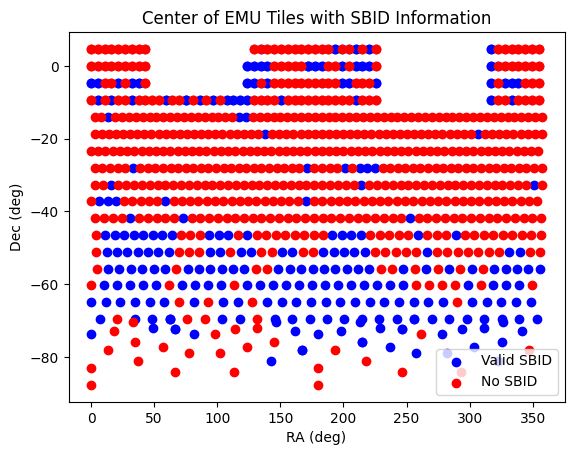

In [6]:
# Plot points with different colors based on whether 'sbid' is valid
plt.scatter(emu_tiles_df.loc[has_sbid, 'center_ra_deg'], emu_tiles_df.loc[has_sbid, 'center_dec_deg'], color='blue', label='Valid SBID')
plt.scatter(emu_tiles_df.loc[~has_sbid, 'center_ra_deg'], emu_tiles_df.loc[~has_sbid, 'center_dec_deg'], color='red', label='No SBID')

plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('Center of EMU Tiles with SBID Information')
plt.legend()
plt.show()

### Plot the actual tiles around the centers for EMU

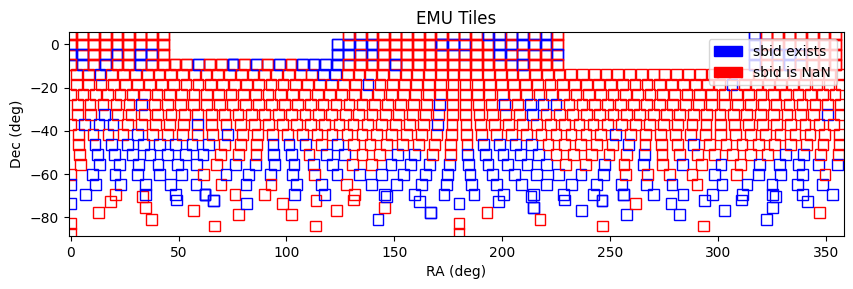

In [7]:
# WARNING: Need to run the code block above before running this code block

# Plot EMU tiles in degrees in flat square projection
plt.figure(figsize=(10, 8))
for i in range(len(emu_tiles_df['field_name'])):
    corners_deg = np.array([
        [emu_tiles_df['rac1_deg'][i], emu_tiles_df['decc1_deg'][i]],
        [emu_tiles_df['rac2_deg'][i], emu_tiles_df['decc2_deg'][i]],
        [emu_tiles_df['rac3_deg'][i], emu_tiles_df['decc3_deg'][i]],
        [emu_tiles_df['rac4_deg'][i], emu_tiles_df['decc4_deg'][i]]
    ])

    color = 'blue' if has_sbid[i] else 'red'
    tile = mplPolygon(corners_deg, closed=True, edgecolor=color, facecolor='none')

    plt.gca().add_patch(tile)

# Add legend
blue_patch = mpatches.Patch(color='blue', label='sbid exists')
red_patch = mpatches.Patch(color='red', label='sbid is NaN')
plt.legend(handles=[blue_patch, red_patch], loc='upper right')

# Set plot labels and title
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('EMU Tiles')
plt.xlim(emu_tiles_df['center_ra_deg'].min() - 1, emu_tiles_df['center_ra_deg'].max() + 1)
plt.ylim(emu_tiles_df['center_dec_deg'].min() - 1, emu_tiles_df['center_dec_deg'].max() + 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

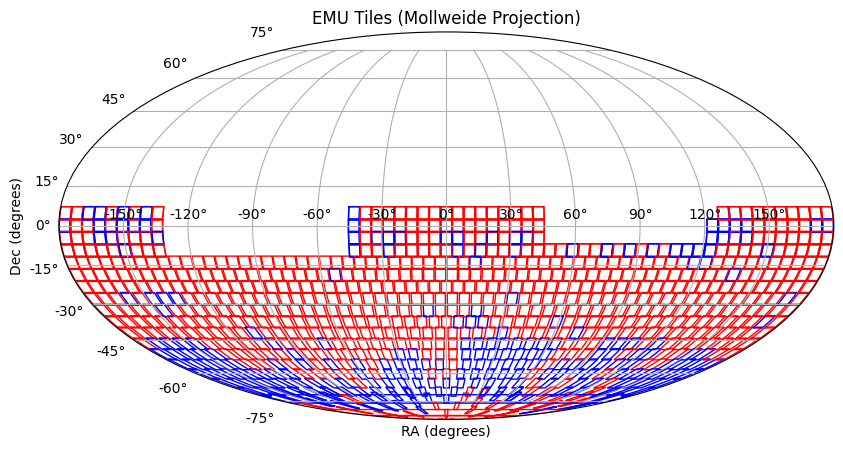

In [8]:
# Create a Mollweide projection plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='mollweide')

# Plot EMU tiles in radians in Mollweide projection
for i in range(len(emu_tiles_df['field_name'])):
    corners_deg = np.array([
        [emu_tiles_df['rac1_deg'][i], emu_tiles_df['decc1_deg'][i]],
        [emu_tiles_df['rac2_deg'][i], emu_tiles_df['decc2_deg'][i]],
        [emu_tiles_df['rac3_deg'][i], emu_tiles_df['decc3_deg'][i]],
        [emu_tiles_df['rac4_deg'][i], emu_tiles_df['decc4_deg'][i]]
    ])

    corners_rad = [(  np.radians(ra - 360 if ra > 180 else ra ), np.radians(dec)) for ra, dec in corners_deg]

    color = 'blue' if has_sbid[i] else 'red'
    tile = mplPolygon(corners_rad, closed=True, edgecolor=color, facecolor='none')

    plt.gca().add_patch(tile)

# Set plot labels and title
ax.set_xlabel('RA (degrees)')
ax.set_ylabel('Dec (degrees)')
ax.set_title('EMU Tiles (Mollweide Projection)')
ax.grid(True)

# Show the plot
plt.show()

## DES DR1 tiles

In [9]:
des_tiles_path = '/home/polaris/Lab_Astro/data/des_dr1.tile_info.fits'

# Create a data frame for the DES tiles (makes it more acessible)
with fits.open(des_tiles_path) as hdul:
    des_tiles_data = hdul[1].data

des_tiles_df = pd.DataFrame(des_tiles_data)


In [10]:
# Create a SkyCoord object for the center of the DES tiles
des_center_coords = SkyCoord(ra=des_tiles_df['ra_cent'], dec=des_tiles_df['dec_cent'], unit=(u.deg, u.deg))

# Create a list of the field name and the correspondy SkyCoord object of the center of the field
des_tiles_dic = [[des_tiles_df['tilename'][i], des_center_coords[i]] for i in range(len(emu_tiles_df))]

In [12]:
# WARNING: Takes a while to run
# # Create a Mollweide projection plot
# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111, projection='mollweide')

# # Plot EMU tiles in radians in Mollweide projection
# for i in range(len(des_tiles_plot_rad)):
#     plt.gca().add_patch(des_tiles_plot_rad[i])

# # Set plot labels and title
# ax.set_xlabel('RA (radians)')
# ax.set_ylabel('Dec (radians)')
# ax.set_title('DES DR1 Tiles (Mollweide Projection)')
# ax.grid(True)

# # Show the plot
# plt.show()

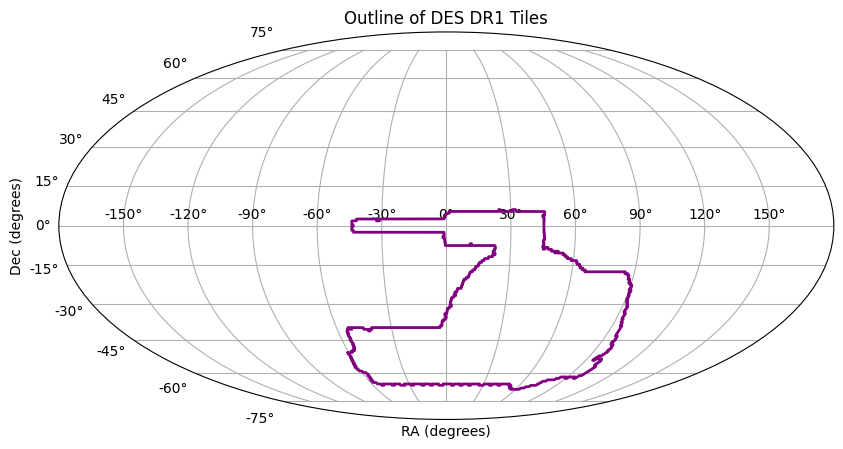

In [11]:
des_tiles_rad = []
for i in range(len(des_tiles_df)):

    corners_deg = [
        (des_tiles_df['rac1'][i],des_tiles_df['decc1'][i]),
        (des_tiles_df['rac2'][i],des_tiles_df['decc2'][i]),
        (des_tiles_df['rac3'][i],des_tiles_df['decc3'][i]),
        (des_tiles_df['rac4'][i],des_tiles_df['decc4'][i])
    ]

    # Shift RA values to center the plot at RA = 0 and convert to radians
    corners_rad = [(  np.radians(ra - 360 if ra > 180 else ra ), np.radians(dec)) for ra, dec in corners_deg]
    des_tiles_rad.append(splyPolygon(corners_rad))

all_tiles = MultiPolygon(des_tiles_rad)

outline = unary_union(all_tiles)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='mollweide')

for geom in outline.geoms if hasattr(outline, 'geoms') else [outline]:
    ra, dec = geom.exterior.xy
    ax.plot(ra, dec, color='purple', linewidth=2)

ax.set_xlabel('RA (degrees)')
ax.set_ylabel('Dec (degrees)')
ax.set_title('Outline of DES DR1 Tiles')
ax.grid(True)

plt.show()

## VIKING DR4 tiles

In [ ]:
viking_tiles_path = '/home/polaris/Lab_Astro/data/VIKING_data/VIKING_tiles.fits'

viking_tiles_df = pd.DataFrame(rows, columns=headers)

## Check for overlap of the DES tiles on EMU

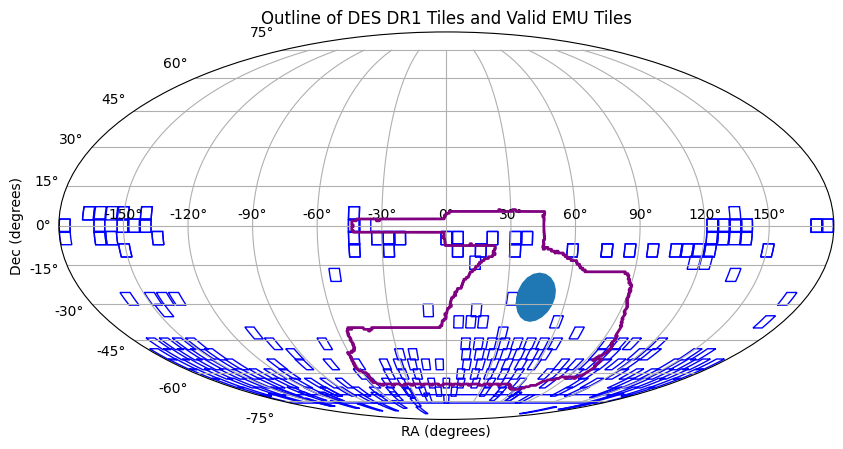

In [ ]:
# Plot the outline of the DES DR1 tiles and valid EMU tiles



all_tiles = MultiPolygon(des_tiles_rad)

outline = unary_union(all_tiles)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='mollweide')

# Plot the outline of the DES DR1 tiles
for geom in outline.geoms if hasattr(outline, 'geoms') else [outline]:
    ra, dec = geom.exterior.xy
    ax.plot(ra, dec, color='purple', linewidth=2)

# Plot the valid EMU tiles
for i in range(len(emu_tiles_df['field_name'])):
    corners_deg = np.array([
        [emu_tiles_df['rac1_deg'][i], emu_tiles_df['decc1_deg'][i]],
        [emu_tiles_df['rac2_deg'][i], emu_tiles_df['decc2_deg'][i]],
        [emu_tiles_df['rac3_deg'][i], emu_tiles_df['decc3_deg'][i]],
        [emu_tiles_df['rac4_deg'][i], emu_tiles_df['decc4_deg'][i]]
    ])

    corners_rad = [(  np.radians(ra - 360 if ra > 180 else ra ), np.radians(dec)) for ra, dec in corners_deg]

    if has_sbid[i]:
        tile = mplPolygon(corners_rad, closed=True, edgecolor='blue', facecolor='none')
        plt.gca().add_patch(tile)


# Euclid Deep Field Fornax
euclid = CirclePolygon((0.78, -0.48), radius=0.17)
plt.gca().add_patch(euclid)

ax.set_xlabel('RA (degrees)')
ax.set_ylabel('Dec (degrees)')
ax.set_title('Outline of DES DR1 Tiles and Valid EMU Tiles')
ax.grid(True)

plt.show()


Number of EMU candidates: 131


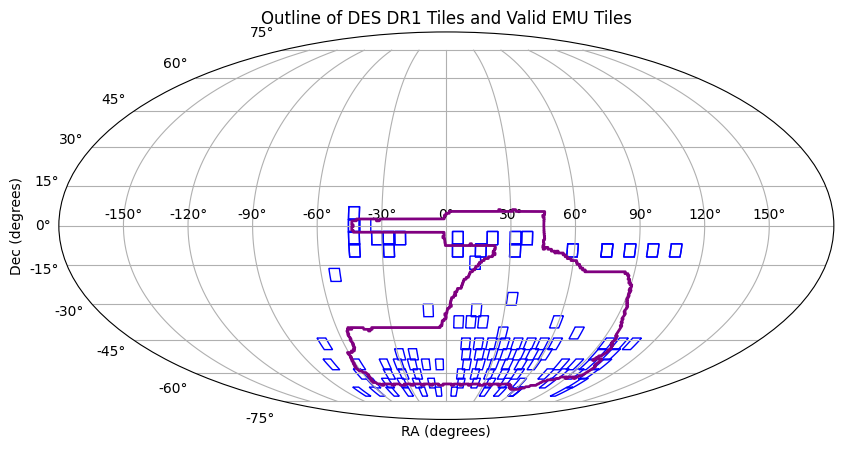

In [ ]:
# Aproximated borders of DES DR1
ra_min1 = 0
ra_max1 = 110

ra_min2 = 280

dec_min = -70.0
dec_max = 10.0

# Find EMU tiles that are within the aproximated DES DR1 borders
emu_tiles_candidates = []

for i in range(len(emu_tiles_df['field_name'])):
    if has_sbid[i]:
        if ((emu_tiles_df['center_ra_deg'][i] > ra_min1 and emu_tiles_df['center_ra_deg'][i] < ra_max1) or (emu_tiles_df['center_ra_deg'][i] > ra_min2)) and emu_tiles_df['center_dec_deg'][i] > dec_min and emu_tiles_df['center_dec_deg'][i] < dec_max:
            emu_tiles_candidates.append(emu_tiles_df['field_name'][i])

print(f'Number of EMU candidates: {len(emu_tiles_candidates)}')

# Plot the outline of the DES DR1 tiles and candidates EMU tiles
all_tiles = MultiPolygon(des_tiles_rad)

outline = unary_union(all_tiles)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='mollweide')

# Plot the outline of the DES DR1 tiles
for geom in outline.geoms if hasattr(outline, 'geoms') else [outline]:
    ra, dec = geom.exterior.xy
    ax.plot(ra, dec, color='purple', linewidth=2)

# Plot the valid EMU tiles
for field_name in emu_tiles_candidates:
    i = emu_tiles_df.index[emu_tiles_df['field_name'] == field_name][0]

    corners_deg = np.array([
        [emu_tiles_df['rac1_deg'][i], emu_tiles_df['decc1_deg'][i]],
        [emu_tiles_df['rac2_deg'][i], emu_tiles_df['decc2_deg'][i]],
        [emu_tiles_df['rac3_deg'][i], emu_tiles_df['decc3_deg'][i]],
        [emu_tiles_df['rac4_deg'][i], emu_tiles_df['decc4_deg'][i]]
    ])

    corners_rad = [( np.radians(ra - 360 if ra > 180 else ra ), np.radians(dec)) for ra, dec in corners_deg]

    tile = mplPolygon(corners_rad, closed=True, edgecolor='blue', facecolor='none')
    plt.gca().add_patch(tile)


ax.set_xlabel('RA (degrees)')
ax.set_ylabel('Dec (degrees)')
ax.set_title('Outline of DES DR1 Tiles and Valid EMU Tiles')
ax.grid(True)

plt.show()

In [16]:
# Precompute SkyCoord objects for EMU and DES tiles
emu_coords = SkyCoord(ra=emu_tiles_df['center_ra_deg'], dec=emu_tiles_df['center_dec_deg'], unit=(u.deg, u.deg))
des_coords = SkyCoord(ra=des_tiles_df['ra_cent'], dec=des_tiles_df['dec_cent'], unit=(u.deg, u.deg))

# Define the search radius in degrees
search_radius = 4 * u.deg

# Initialize the result dictionary
emu_and_des = defaultdict(list)

# Iterate through all EMU tiles
for k, emu_field_name in enumerate(emu_tiles_candidates):
    # Get the index of the current EMU tile
    i = emu_tiles_df.index[emu_tiles_df['field_name'] == emu_field_name][0]

    # Get the SkyCoord object for the current EMU tile
    center_tile = emu_coords[i]

    # Filter DES tiles based on RA and Dec ranges
    ra_diff = np.abs(des_coords.ra.deg - center_tile.ra.deg)
    ra_diff = np.minimum(ra_diff, 360 - ra_diff)  # Handle RA wrapping
    dec_diff = np.abs(des_coords.dec.deg - center_tile.dec.deg)

    # Apply the RA and Dec range filters
    mask = (ra_diff <= search_radius.value) & (dec_diff <= search_radius.value)

    # Further filter by actual angular separation
    close_des_tiles = des_coords[mask]
    separations = center_tile.separation(close_des_tiles)
    within_radius = separations < search_radius

    # Add matching DES tiles to the result
    matching_des_indices = np.where(mask)[0][within_radius]
    emu_and_des[emu_field_name] = des_tiles_df['tilename'].iloc[matching_des_indices].tolist()

    # Print progress
    print(f"Processed EMU Field: {emu_field_name}")

# Print the final result
print(emu_and_des)

# Save to text file
output_file = "/home/polaris/Lab_Astro/data/emu_and_des_results.txt"

with open(output_file, "w") as file:
    json.dump(emu_and_des, file, indent=4)

print(f"Dictionary saved to {output_file}")

Processed EMU Field: EMU_0021-04A
Processed EMU Field: EMU_0021-04B
Processed EMU Field: EMU_0021-09A
Processed EMU Field: EMU_0021-09B
Processed EMU Field: EMU_0026-37
Processed EMU Field: EMU_0027-69
Processed EMU Field: EMU_0041-60
Processed EMU Field: EMU_0044-46
Processed EMU Field: EMU_0046-64
Processed EMU Field: EMU_0049-51
Processed EMU Field: EMU_0052-37
Processed EMU Field: EMU_0054-14
Processed EMU Field: EMU_0054-55
Processed EMU Field: EMU_0102-32
Processed EMU Field: EMU_0104-09A
Processed EMU Field: EMU_0104-09B
Processed EMU Field: EMU_0114-46
Processed EMU Field: EMU_0118-37
Processed EMU Field: EMU_0121-51
Processed EMU Field: EMU_0122-60
Processed EMU Field: EMU_0125-04A
Processed EMU Field: EMU_0125-04B
Processed EMU Field: EMU_0130-55
Processed EMU Field: EMU_0132-64
Processed EMU Field: EMU_0144-46
Processed EMU Field: EMU_0154-51
Processed EMU Field: EMU_0203-60
Processed EMU Field: EMU_0204-41
Processed EMU Field: EMU_0205-55
Processed EMU Field: EMU_0208-04A
P

In [ ]:
# The plotting order of the patches is inverse to the order they are show.

def plot_intersect(emu_field_name, des_tile_list):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    
    # Define EMU tile
    # Find the index of the EMU tile
    i = emu_tiles_df.index[emu_tiles_df['field_name'] == emu_field_name][0]

    # Get EMU tile center and wrap RA to [-180, 180]
    emu_ra_center = (emu_tiles_df['center_ra_deg'][i] + 180) % 360 - 180
    emu_dec_center = emu_tiles_df['center_dec_deg'][i]

    # Plot the DES tiles
    for j in range(len(des_tiles_df)):
        #  Wrap RA to [-180, 180]
        des_corners_deg = [
            ((des_tiles_df['rac1'][j] + 180) % 360 - 180, des_tiles_df['decc1'][j]),
            ((des_tiles_df['rac2'][j] + 180) % 360 - 180, des_tiles_df['decc2'][j]),
            ((des_tiles_df['rac3'][j] + 180) % 360 - 180, des_tiles_df['decc3'][j]),
            ((des_tiles_df['rac4'][j] + 180) % 360 - 180, des_tiles_df['decc4'][j])
        ]

        if des_tiles_df['tilename'][j] in des_tile_list:
            des_polygon = mplPolygon(des_corners_deg, closed=True, edgecolor='green', facecolor='none', linewidth=2)
        else:
            des_polygon = mplPolygon(des_corners_deg, closed=True, edgecolor='red', facecolor='none')
        
        ax.add_patch(des_polygon)

    # Plot the EMU tile
    emu_corners_deg = np.array([
        [(emu_tiles_df['rac1_deg'][i] + 180) % 360 - 180, emu_tiles_df['decc1_deg'][i]],
        [(emu_tiles_df['rac2_deg'][i] + 180) % 360 - 180, emu_tiles_df['decc2_deg'][i]],
        [(emu_tiles_df['rac3_deg'][i] + 180) % 360 - 180, emu_tiles_df['decc3_deg'][i]],
        [(emu_tiles_df['rac4_deg'][i] + 180) % 360 - 180, emu_tiles_df['decc4_deg'][i]]
    ])

    emu_polygon = mplPolygon(emu_corners_deg, closed=True, edgecolor='blue', facecolor='none', linewidth=2)
    ax.add_patch(emu_polygon)

    # Set limits of the plot
    ra_min_deg = emu_ra_center - 10
    ra_max_deg = emu_ra_center + 10
    dec_min_deg = emu_dec_center - 10
    dec_max_deg = emu_dec_center + 10

    ax.set_title(f'EMU and DES Tiles (Zoomed-In on {emu_field_name})', fontsize=14)
    ax.set_xlabel('RA (degrees)')
    ax.set_ylabel('DEC (degrees)')
    
    ax.set_xlim(ra_min_deg, ra_max_deg)
    ax.set_ylim(dec_min_deg, dec_max_deg)
   
    image_path = '/home/polaris/Lab_Astro/data/matched_data/des_tiles/' + str(emu_field_name) + '.png'

    plt.savefig(image_path)

    print('Imaged saved to: ', image_path)

In [ ]:
for i in range(128):
    emu_field, des_tiles = list(emu_and_des.items())[i]
    print(f'EMU Field: {emu_field}')
    print(f'DES Tiles: {des_tiles}')
    plot_intersect(emu_field, des_tiles)